In [1]:
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt

In [2]:
# The pressure Poisson equation that's written above can be hard to write out without typos. 
# The fuction build_up_b below represents the contents of the square brackets, 
# so that the entirety of the PPE is slightly more manageable.
def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b


In [3]:
def pressure_poisson(p, dx, dy, b, nit):    
    for q in range(nit):
        p[1:-1, 1:-1] = (((p[1:-1, 2:] + p[1:-1, 0:-2]) * dy**2 + 
                          (p[2:, 1:-1] + p[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [4]:
# Finally, the rest of the cavity flow equations are wrapped inside the fuction cavity_flow, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

def cavity_flow(nt, nit, u, v, dt, dx, dy, b, p, rho, nu):
    print('caviry dlow called: nt=',nt)

    for n in range(nt):        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, nit)
        
        u[1:-1, 1:-1] = (u[1:-1, 1:-1]-
                         u[1:-1, 1:-1] * dt / dx *
                        (u[1:-1, 1:-1] - u[1:-1, 0:-2]) -
                         v[1:-1, 1:-1] * dt / dy *
                        (u[1:-1, 1:-1] - u[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[0:-2, 1:-1])))

        v[1:-1,1:-1] = (v[1:-1, 1:-1] -
                        u[1:-1, 1:-1] * dt / dx *
                       (v[1:-1, 1:-1] - v[1:-1, 0:-2]) -
                        v[1:-1, 1:-1] * dt / dy *
                       (v[1:-1, 1:-1] - v[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [5]:
# Helper function for plots
def generate_plots(X, Y, p, u, v):
    stepX = int(X.shape[0] / 20)
    stepY = int(Y.shape[0] / 20)
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
    pyplot.colorbar()
    # plotting the pressure field outlines
    pyplot.contour(X, Y, p, cmap=cm.viridis)  
    plt.savefig('p_NS.png',bbox_inches='tight')
    # plotting velocity field
    pyplot.quiver(X[::stepX, ::stepY], Y[::stepX, ::stepY], u[::stepX, ::stepY], v[::stepX, ::stepY]) 
    pyplot.xlabel('X')
    pyplot.ylabel('Y')
    plt.savefig('vect_NS.png',bbox_inches='tight')


    ########################################## iso u
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    im=plt.pcolormesh(X,Y,p, vmin=-1,vmax=1,cmap=plt.get_cmap('hot'),shading='gouraud')
    fig1.colorbar(im)
    plt.arrow(x=0.8, y=2.1, dx=0.4, dy=0, width=.03,facecolor='black')
    plt.text(1,2.2,'$U_{wall}$')
    plt.axis('equal')
    # plt.colorbar()
    plt.axis('off')
    plt.box(on=None)
    plt.savefig('u_NS_iso.png')

caviry dlow called: nt= 100


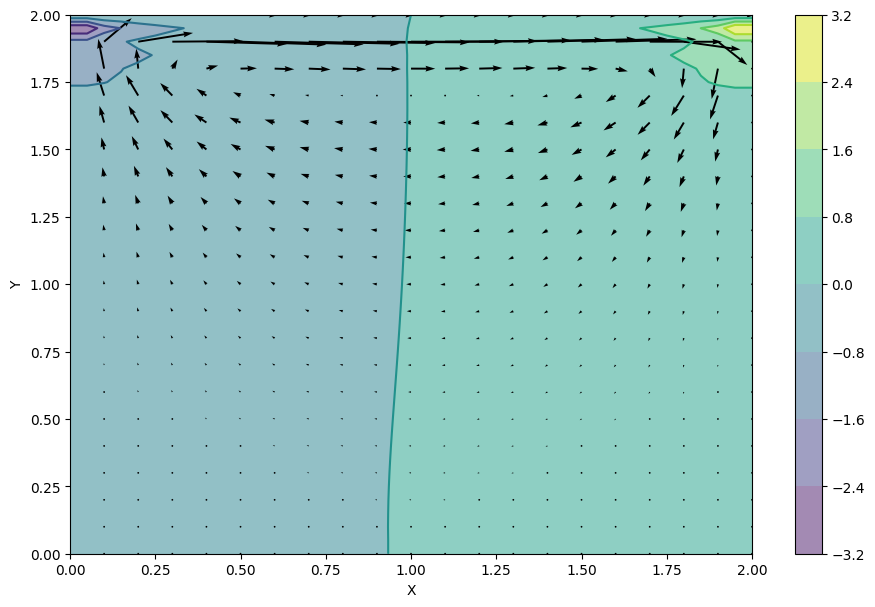

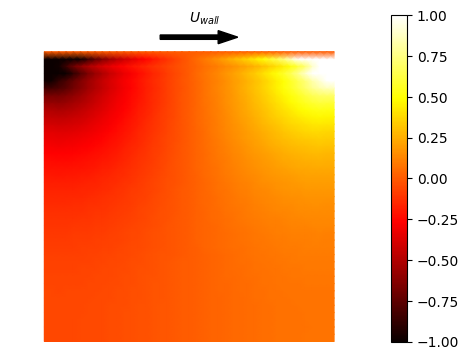

In [6]:
import numpy as np
# Let's start with nt = 100 and see what the solver gives us:
plt.interactive(True)

meshscale = 1
nx = 41 * meshscale
ny = 41 * meshscale
nit = 50 * meshscale
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = .1
dt = .001 / meshscale
nt = 100


x = np.linspace(0, 2, nx, dtype = np.float64)
y = np.linspace(0, 2, ny, dtype = np.float64)
X, Y = np.meshgrid(x, y)
u = np.zeros((ny, nx), dtype = np.float64)
v = np.zeros((ny, nx), dtype = np.float64)
p = np.zeros((ny, nx), dtype = np.float64)
b = np.zeros((ny, nx), dtype = np.float64)



u, v, p = cavity_flow(nt, nit, u, v, dt, dx, dy, b, p, rho, nu)

generate_plots(X, Y, p, u, v)

# Profiling
In this section we profile the code. We do one loop over a 410x410 mesh, where we iterate the poisson loop 158 times with a timestep of 3.22e-5.

caviry dlow called: nt= 100
         284 function calls in 16.397 seconds

   Ordered by: internal time
   List reduced from 38 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100   15.477    0.155   15.477    0.155 /tmp/ipykernel_5109/2730349561.py:1(pressure_poisson)
        1    0.667    0.667   16.397   16.397 /tmp/ipykernel_5109/3264786233.py:3(cavity_flow)
      100    0.253    0.003    0.253    0.003 /tmp/ipykernel_5109/10133553.py:4(build_up_b)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.000    0.000    0.000    0.000 /usr/lib/python3.10/codeop.py:117(__call__)
        4    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py:626(write)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py:621(send)
        2    0.000    0.000   16.397    8.199 /usr/local/lib/python3.10/dist

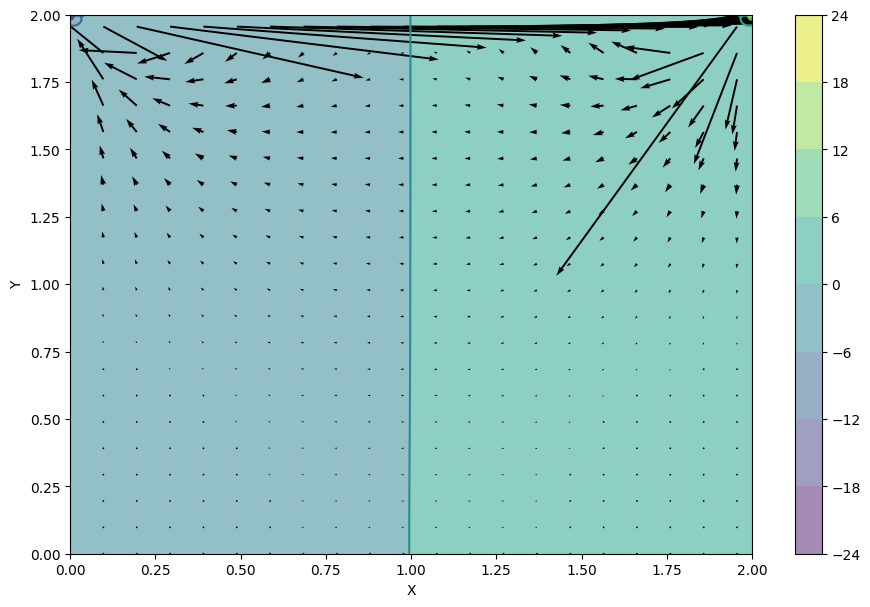

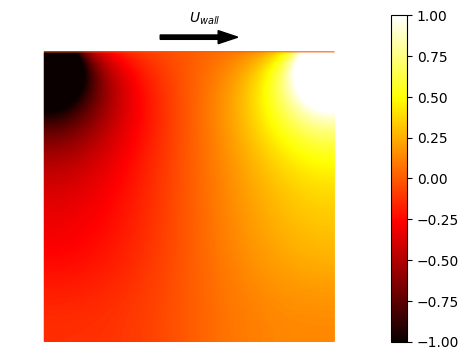

In [7]:
import cProfile, pstats
import numpy as np

meshscale = 10
nx = 41 * meshscale
ny = 41 * meshscale
nit = int(50 * meshscale ** 0.5)
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = .1
dt = .001 / meshscale ** 1.5
nt = 100

x = np.linspace(0, 2, nx, dtype = np.float64)
y = np.linspace(0, 2, ny, dtype = np.float64)
X, Y = np.meshgrid(x, y)
u = np.zeros((ny, nx), dtype = np.float64)
v = np.zeros((ny, nx), dtype = np.float64)
p = np.zeros((ny, nx), dtype = np.float64)
b = np.zeros((ny, nx), dtype = np.float64)

profiler = cProfile.Profile()
profiler.enable()
u, v, p = cavity_flow(nt, nit, u, v, dt, dx, dy, b, p, rho, nu)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats(10)

generate_plots(X, Y, p, u, v)

# CUPY version

In [8]:
import cProfile, pstats
import cupy as np
import cupy as cp

meshscale = 10
nx = 41 * meshscale
ny = 41 * meshscale
nit = int(50 * meshscale ** 0.5)
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = .1
dt = .001 / meshscale ** 1.5
nt = 100

x = np.linspace(0, 2, nx, dtype = np.float64)
y = np.linspace(0, 2, ny, dtype = np.float64)
X, Y = np.meshgrid(x, y)
u = np.zeros((ny, nx), dtype = np.float64)
v = np.zeros((ny, nx), dtype = np.float64)
p = np.zeros((ny, nx), dtype = np.float64)
b = np.zeros((ny, nx), dtype = np.float64)

profiler = cProfile.Profile()
profiler.enable()
u, v, p = cavity_flow(nt, nit, u, v, dt, dx, dy, b, p, rho, nu)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('tottime')
stats.print_stats(7)

generate_plots(cp.asnumpy(X), cp.asnumpy(Y), cp.asnumpy(p), cp.asnumpy(u), cp.asnumpy(v))


CUDARuntimeError: cudaErrorUnknown: unknown error

In [1]:
import cupy
cupy.show_config()

OS                        : Linux-6.2.0-36-generic-x86_64-with-glibc2.35
Python Version            : 3.10.12
CuPy Version              : 12.2.0
CuPy Platform             : NVIDIA CUDA
NumPy Version             : 1.26.1
SciPy Version             : 1.11.3
Cython Build Version      : 0.29.36
Cython Runtime Version    : None
CUDA Root                 : /usr/local/cuda
nvcc PATH                 : /usr/local/cuda/bin/nvcc
CUDA Build Version        : 12010
CUDA Driver Version       : 12010
CUDA Runtime Version      : 12010
cuBLAS Version            : (available)
cuFFT Version             : 11002
cuRAND Version            : 10302
cuSOLVER Version          : (11, 4, 5)
cuSPARSE Version          : (available)
NVRTC Version             : (12, 1)
Thrust Version            : 200001
CUB Build Version         : 200001
Jitify Build Version      : <unknown>
cuDNN Build Version       : None
cuDNN Version             : None
NCCL Build Version        : 21701
NCCL Runtime Version      : 21701
cuTENSOR Vers

/usr/local/lib/python3.10/dist-packages/cupyx/_runtime.py:279: UserWarning: Failed to detect number of GPUs: cudaErrorUnknown: unknown error
  warnings.warn(f'Failed to detect number of GPUs: {e}')
